In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
torch.__version__

'2.5.1+cu121'

## Data Preprocessing

In [3]:
dataset = pd.read_csv('Churn_Modelling.csv')
X = dataset.iloc[:, 3:-1].values # pa轉np
y = dataset.iloc[:, -1].values # pa轉np
X

array([[619, 'France', 'Female', ..., 1, 1, 101348.88],
       [608, 'Spain', 'Female', ..., 0, 1, 112542.58],
       [502, 'France', 'Female', ..., 1, 0, 113931.57],
       ...,
       [709, 'France', 'Female', ..., 0, 1, 42085.58],
       [772, 'Germany', 'Male', ..., 1, 0, 92888.52],
       [792, 'France', 'Female', ..., 1, 0, 38190.78]], dtype=object)

##  Encoding categorical data
- 當數據有序或類別較少時，選擇標籤編碼(Label Encoding)。
- 當數據無序且類別較多時，選擇獨熱編碼(One-Hot Encoding)。

In [4]:
# NOTE: 對 "Gender" 欄進行標籤編碼(Label Encoding) -> 當特徵只有兩類（binary classification）且沒有明顯的順序問題
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
X[:, 2] = le.fit_transform(X[:, 2])
X

array([[619, 'France', 0, ..., 1, 1, 101348.88],
       [608, 'Spain', 0, ..., 0, 1, 112542.58],
       [502, 'France', 0, ..., 1, 0, 113931.57],
       ...,
       [709, 'France', 0, ..., 0, 1, 42085.58],
       [772, 'Germany', 1, ..., 1, 0, 92888.52],
       [792, 'France', 0, ..., 1, 0, 38190.78]], dtype=object)

In [5]:
# NOTE: 對 "Geography" 欄進行獨熱編碼(One-Hot Encoding) -> 當分類特徵是無序的（nominal），例如：國家、顏色等
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [1])], remainder='passthrough')
X = np.array(ct.fit_transform(X))
X  # 查看編碼後的數據

array([[1.0, 0.0, 0.0, ..., 1, 1, 101348.88],
       [0.0, 0.0, 1.0, ..., 0, 1, 112542.58],
       [1.0, 0.0, 0.0, ..., 1, 0, 113931.57],
       ...,
       [1.0, 0.0, 0.0, ..., 0, 1, 42085.58],
       [0.0, 1.0, 0.0, ..., 1, 0, 92888.52],
       [1.0, 0.0, 0.0, ..., 1, 0, 38190.78]], dtype=object)

## Splitting the dataset


In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 12), (2000, 12), (8000,), (2000,))

## Feature Scaling
- X經過特徵縮放處裡

In [7]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [8]:
X_train

array([[ 0.99153582, -0.57369368, -0.5744635 , ...,  0.64959174,
         0.97603703,  0.70880522],
       [ 0.99153582, -0.57369368, -0.5744635 , ..., -1.53942844,
         0.97603703,  0.74704204],
       [ 0.99153582, -0.57369368, -0.5744635 , ..., -1.53942844,
         0.97603703,  0.86031147],
       ...,
       [ 0.99153582, -0.57369368, -0.5744635 , ...,  0.64959174,
        -1.02455129, -0.39794774],
       [ 0.99153582, -0.57369368, -0.5744635 , ...,  0.64959174,
         0.97603703, -0.80445466],
       [ 0.99153582, -0.57369368, -0.5744635 , ...,  0.64959174,
         0.97603703, -1.64310116]])

## 開始使用Pytorch進行訓練
- 將數據轉換為 PyTorch 張量

In [9]:
X_train = torch.tensor(X_train, dtype=torch.float32).cuda()
X_test = torch.tensor(X_test, dtype=torch.float32).cuda()
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).cuda()
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).cuda()

## Building the ANN
- 這個模型包括：
  - 一個輸入層。
  - 兩個隱藏層。
  - 一個輸出層。
- 激活函數是 ReLU，輸出層使用了 Sigmoid 函數，通常用於二分類問題

In [10]:
# nn.Module 是 PyTorch 的所有神經網絡的基類。
class ANNModel(nn.Module):
    def __init__(self):
        super(ANNModel, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 6) # 連接層 (Fully Connected Layer)。輸入1，輸出6
        self.relu = nn.ReLU() # 激活函數
        self.fc2 = nn.Linear(6, 6) # 全連接層
        self.fc3 = nn.Linear(6, 1) # 全連接層，輸入6，輸出1
        self.sigmoid = nn.Sigmoid() # 輸出層激活函數

    # 定義了數據如何通過這個網絡
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x
    
# 初始化模型
model = ANNModel().cuda()

## Training the ANN

In [11]:
# 定義損失函數和優化器
criterion = nn.BCELoss()  # 二元交叉熵損失
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
epochs = 100
batch_size = 32

for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for i in range(0, len(X_train), batch_size):
        X_batch = X_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]

        # 前向傳播
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        # 反向傳播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 累積損失
        epoch_loss += loss.item()

        # 計算準確率
        predictions = (outputs > 0.5).float()  # 將概率轉為 0 或 1
        correct_predictions += (predictions == y_batch).sum().item()
        total_samples += y_batch.size(0)

    # 計算每個 epoch 的平均損失和準確率
    epoch_loss /= len(X_train) / batch_size
    accuracy = correct_predictions / total_samples

    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}')


Epoch 1/100, Loss: 0.6022, Accuracy: 0.6526
Epoch 2/100, Loss: 0.4496, Accuracy: 0.7973
Epoch 3/100, Loss: 0.4350, Accuracy: 0.7973
Epoch 4/100, Loss: 0.4297, Accuracy: 0.8084
Epoch 5/100, Loss: 0.4254, Accuracy: 0.8200
Epoch 6/100, Loss: 0.4213, Accuracy: 0.8257
Epoch 7/100, Loss: 0.4171, Accuracy: 0.8265
Epoch 8/100, Loss: 0.4129, Accuracy: 0.8287
Epoch 9/100, Loss: 0.4085, Accuracy: 0.8287
Epoch 10/100, Loss: 0.4045, Accuracy: 0.8307
Epoch 11/100, Loss: 0.4004, Accuracy: 0.8319
Epoch 12/100, Loss: 0.3964, Accuracy: 0.8329
Epoch 13/100, Loss: 0.3925, Accuracy: 0.8331
Epoch 14/100, Loss: 0.3887, Accuracy: 0.8325
Epoch 15/100, Loss: 0.3851, Accuracy: 0.8336
Epoch 16/100, Loss: 0.3815, Accuracy: 0.8350
Epoch 17/100, Loss: 0.3783, Accuracy: 0.8414
Epoch 18/100, Loss: 0.3754, Accuracy: 0.8434
Epoch 19/100, Loss: 0.3726, Accuracy: 0.8449
Epoch 20/100, Loss: 0.3699, Accuracy: 0.8454
Epoch 21/100, Loss: 0.3675, Accuracy: 0.8468
Epoch 22/100, Loss: 0.3653, Accuracy: 0.8481
Epoch 23/100, Loss:

## Making the predictions 

In [14]:
# 預測單個觀測結果
sample = sc.transform([[1, 0, 0, 600, 1, 40, 3, 60000, 2, 1, 1, 50000]]) # 特徵壓縮
sample_tensor = torch.tensor(sample, dtype=torch.float32).cuda()
print((model(sample_tensor) > 0.5).item())  # 是否留住客戶

False


In [15]:
y_pred = model(X_test)
y_pred = (y_pred > 0.5).float()

## evaluating

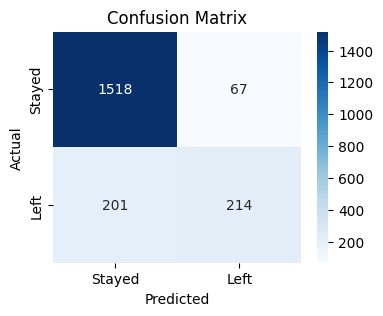

In [23]:
# 可視化混淆矩陣
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

cm = confusion_matrix(y_test.cpu().numpy(), y_pred.cpu().detach().numpy())

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Stayed', 'Left'], yticklabels=['Stayed', 'Left'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
